## New Dataset: Predicting 'EverGreenness' of Web Content

_Evergreen_ sites are always relevant. As opposed to breaking news or current news, evergreen websites maintain traffic no matter the time or season.

#### Data Dictionary

We will be using the [Kaggle StumbleUpon Evergreen Classification Challenge.](https://www.kaggle.com/c/stumbleupon)

FieldName|Type|Description
---------|----|-----------
url|string|Url of the webpage to be classified
title|string|Title of the article
body|string|Body text of article
urlid|integer| StumbleUpon's unique identifier for each url
boilerplate|json|Boilerplate text
alchemy_category|string|Alchemy category (per the publicly available Alchemy API found at www.alchemyapi.com)
alchemy_category_score|double|Alchemy category score (per the publicly available Alchemy API found at www.alchemyapi.com)
avglinksize| double|Average number of words in each link
commonlinkratio_1|double|# of links sharing at least 1 word with 1 other links / # of links
commonlinkratio_2|double|# of links sharing at least 1 word with 2 other links / # of links
commonlinkratio_3|double|# of links sharing at least 1 word with 3 other links / # of links
commonlinkratio_4|double|# of links sharing at least 1 word with 4 other links / # of links
compression_ratio|double|Compression achieved on this page via gzip (measure of redundancy)
embed_ratio|double|Count of number of <embed> usage
frameBased|integer (0 or 1)|A page is frame-based (1) if it has no body markup but have a frameset markup
frameTagRatio|double|Ratio of iframe markups over total number of markups
hasDomainLink|integer (0 or 1)|True (1) if it contains an <a> with an url with domain
html_ratio|double|Ratio of tags vs text in the page
image_ratio|double|Ratio of <img> tags vs text in the page
is_news|integer (0 or 1) | True (1) if StumbleUpon's news classifier determines that this webpage is news
lengthyLinkDomain| integer (0 or 1)|True (1) if at least 3 <a> 's text contains more than 30 alphanumeric characters
linkwordscore|double|Percentage of words on the page that are in hyperlink's text
news_front_page| integer (0 or 1)|True (1) if StumbleUpon's news classifier determines that this webpage is front-page news
non_markup_alphanum_characters|integer| Page's text's number of alphanumeric characters
numberOfLinks|integer Number of <a>|markups
numwords_in_url| double|Number of words in url
parametrizedLinkRatio|double|A link is parametrized if it's url contains parameters or has an attached onClick event
spelling_errors_ratio|double|Ratio of words not found in wiki (considered to be a spelling mistake)
label|integer (0 or 1)|User-determined label. Either evergreen (1) or non-evergreen (0); available for train.tsv only

We will revisit the data science workflow in order to explore the dataset and determine important characteristics for "evergreen" websites.

1. Prior to looking at the available data, brainstorm 3 - 5 characteristics that would be useful for predicting evergreen websites.
2. After looking at the dataset, can you model or quantify any of the characteristics you wanted?
  - For instance, if you believe high-image content websites are likely to be evergreen, then how would you build a feature that represents high image content?
  - Or if you believe weather content ISN'T likely to be evergreen, then how would you build a feature to reflect that?            
3. Does being a news site affect "evergreen-ness"? Compute or plot the percent of evergreen news sites.
4. Does category in general affect evergreen-ness? Plot the rate of evergreen sites for all Alchemy categories.
5. How many articles are there per category?
6. Create a feature for the title containing "recipe". Is the % of evergreen websites higher or lower on pages that have "recipe" in the the title?

### What are 3 - 5 characteristics that you think might predict 'evergreen-ness'?

   1. Write
   2. Your
   3. Ideas
   4. Here

In [75]:
import numpy as np
import pandas as pd
import json
from sklearn.datasets import load_iris
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score
import pydotplus 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid", font_scale=1.5)
%matplotlib inline

# Load data
df = pd.read_csv("../../../datasets/stumbleupon.tsv", sep='\t')
df.iloc[0]

url                               http://www.bloomberg.com/news/2010-12-23/ibm-p...
urlid                                                                          4042
boilerplate                       {"title":"IBM Sees Holographic Calls Air Breat...
alchemy_category                                                           business
alchemy_category_score                                                     0.789131
avglinksize                                                                 2.05556
commonlinkratio_1                                                          0.676471
commonlinkratio_2                                                          0.205882
commonlinkratio_3                                                         0.0470588
commonlinkratio_4                                                         0.0235294
compression_ratio                                                          0.443783
embed_ratio                                                                 

(array([ 3599.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  3796.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

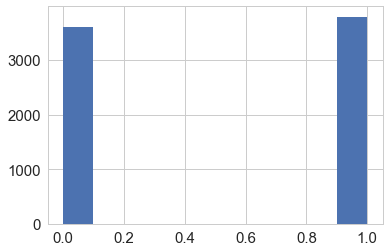

In [20]:
# What's the distribution of evergreen vs. non-evergreen?

plt.hist(df.label)

### Does being a news site affect 'evergreen-ness'? 


In [21]:
df.groupby('is_news').label.mean()

is_news
1    0.516916
?    0.507562
Name: label, dtype: float64

In [22]:
df.is_news.value_counts()

1    4552
?    2843
Name: is_news, dtype: int64

### Does category have an effect on evergreenness?

* Let's plot the rate of evergreenness for each category

In [23]:
df.groupby('alchemy_category').label.mean()

alchemy_category
?                     0.502135
arts_entertainment    0.371945
business              0.711364
computer_internet     0.246622
culture_politics      0.457726
gaming                0.368421
health                0.573123
law_crime             0.419355
recreation            0.684296
religion              0.416667
science_technology    0.456747
sports                0.205263
unknown               0.333333
weather               0.000000
Name: label, dtype: float64

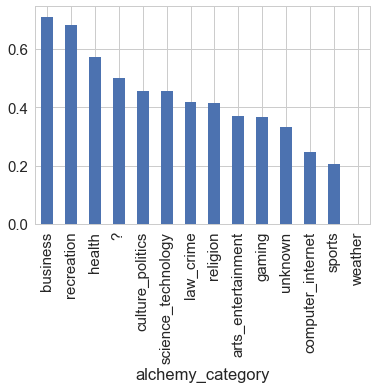

In [24]:
df.groupby('alchemy_category').label.mean().sort_values(ascending=False).plot(kind='bar')

### How many articles are there per category?

* We can do this using either value_counts or a groupby.

In [25]:
# Using a groupby
df.groupby('alchemy_category').label.count()

alchemy_category
?                     2342
arts_entertainment     941
business               880
computer_internet      296
culture_politics       343
gaming                  76
health                 506
law_crime               31
recreation            1229
religion                72
science_technology     289
sports                 380
unknown                  6
weather                  4
Name: label, dtype: int64

In [26]:
# now values counts
df.alchemy_category.value_counts()

?                     2342
recreation            1229
arts_entertainment     941
business               880
health                 506
sports                 380
culture_politics       343
computer_internet      296
science_technology     289
gaming                  76
religion                72
law_crime               31
unknown                  6
weather                  4
Name: alchemy_category, dtype: int64

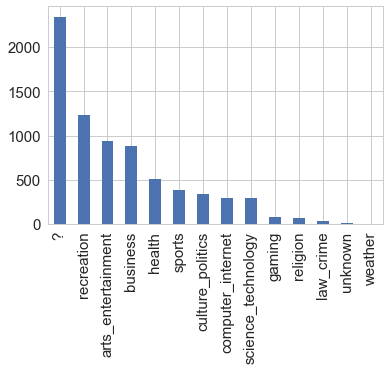

In [27]:
df.alchemy_category.value_counts().plot(kind='bar')

### Create a feature that indicates whether the title contains the word 'recipe'

In [28]:
# First we need to split the 'boilerplate' column into 'title' and 'body'

df['title'] = df['boilerplate'].apply(lambda x: json.loads(x).get('title'))
df['body'] = df['boilerplate'].apply(lambda x: json.loads(x).get('body'))

In [29]:
# The title
print df['title'][2]

Fruits that Fight the Flu fruits that fight the flu | cold & flu | men's health


In [30]:
# The body
print df['body'][2]

Apples The most popular source of antioxidants in our diet one apple has an antioxidant effect equivalent to 1 500 mg of vitamin C Apples are loaded with protective flavonoids which may prevent heart disease and cancer Next Papayas With 250 percent of the RDA of vitamin C a papaya can help kick a cold right out of your system The beta carotene and vitamins C and E in papayas reduce inflammation throughout the body lessening the effects of asthma Next Cranberries Cranberries have more antioxidants than other common fruits and veggies One serving has five times the amount in broccoli Cranberries are a natural probiotic enhancing good bacteria levels in the gut and protecting it from foodborne illnesses Next Grapefruit Loaded with vitamin C grapefruit also contains natural compounds called limonoids which can lower cholesterol The red varieties are a potent source of the cancer fighting substance lycopene Next Bananas One of the top food sources of vitamin B6 bananas help reduce fatigue d

In [31]:
# Create recipe binary column from 'title'

df['recipe_in_title'] = df['title'].str.contains('recipe')

In [32]:
df.groupby('recipe_in_title').label.mean()

recipe_in_title
False    0.494380
True     0.892351
Name: label, dtype: float64

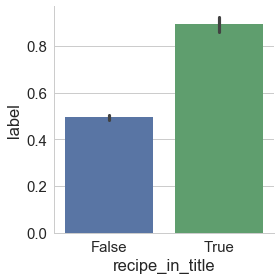

In [33]:
# Create quick bar chart to see if having the word 'recipe' affects the label

sns.factorplot(x='recipe_in_title', y='label', kind='bar', data=df)

### Partner Up: Take 10 minutes to explore some other relationships

* Are there other visualizations or groupings that can give us some insights into the data?
* Try playing with words other than 'recipe'
* How does the presence of images effect the evergreen-ness?

In [34]:
df['food_in_body'] = df['body'].str.contains('food')

In [35]:
df.groupby('food_in_body').label.mean()

food_in_body
False    0.427640
True     0.774904
Name: label, dtype: float64

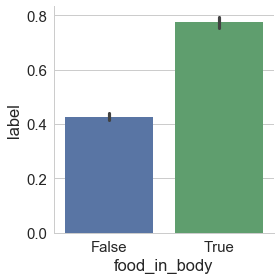

In [36]:
sns.factorplot(x='food_in_body', y='label', kind='bar', data=df)

### Prepare the data for modelling

In [37]:
# Create dummies for the alchemy category
# Remember to drop one of the columns!

df = df.dropna()

alch_dummies = pd.get_dummies(df['alchemy_category'], prefix='alchemy_cat', drop_first=True)

df = pd.concat([df, alch_dummies], axis=1)
df.drop('alchemy_category', axis=1, inplace=True)

In [38]:
df.head()

,url,urlid,boilerplate,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,compression_ratio,...,alchemy_cat_culture_politics,alchemy_cat_gaming,alchemy_cat_health,alchemy_cat_law_crime,alchemy_cat_recreation,alchemy_cat_religion,alchemy_cat_science_technology,alchemy_cat_sports,alchemy_cat_unknown,alchemy_cat_weather
0,http://www.bloomberg.com/news/2010-12-23/ibm-p...,4042,"{""title"":""IBM Sees Holographic Calls Air Breat...",0.789131,2.055556,0.676471,0.205882,0.047059,0.023529,0.443783,...,0,0,0,0,0,0,0,0,0,0
1,http://www.popsci.com/technology/article/2012-...,8471,"{""title"":""The Fully Electronic Futuristic Star...",0.574147,3.677966,0.508021,0.288770,0.213904,0.144385,0.468649,...,0,0,0,0,1,0,0,0,0,0
2,http://www.menshealth.com/health/flu-fighting-...,1164,"{""title"":""Fruits that Fight the Flu fruits tha...",0.996526,2.382883,0.562016,0.321705,0.120155,0.042636,0.525448,...,0,0,1,0,0,0,0,0,0,0
3,http://www.dumblittleman.com/2007/12/10-foolpr...,6684,"{""title"":""10 Foolproof Tips for Better Sleep ""...",0.801248,1.543103,0.400000,0.100000,0.016667,0.000000,0.480725,...,0,0,1,0,0,0,0,0,0,0
4,http://bleacherreport.com/articles/1205138-the...,9006,"{""title"":""The 50 Coolest Jerseys You Didn t Kn...",0.719157,2.676471,0.500000,0.222222,0.123457,0.043210,0.446143,...,0,0,0,0,0,0,0,1,0,0


In [39]:
# Set the features that we'll use for modeling

features = ['image_ratio','html_ratio','recipe_in_title']
features.extend(alch_dummies.columns.tolist())

In [40]:
features

['image_ratio',
 'html_ratio',
 'recipe_in_title',
 'alchemy_cat_arts_entertainment',
 'alchemy_cat_business',
 'alchemy_cat_computer_internet',
 'alchemy_cat_culture_politics',
 'alchemy_cat_gaming',
 'alchemy_cat_health',
 'alchemy_cat_law_crime',
 'alchemy_cat_recreation',
 'alchemy_cat_religion',
 'alchemy_cat_science_technology',
 'alchemy_cat_sports',
 'alchemy_cat_unknown',
 'alchemy_cat_weather']

In [41]:
# Set X and y
X = df[features]
y = df.label

In [42]:
# Let's try logistic regression and KNN

logreg = LogisticRegression()
knn = KNeighborsClassifier()

In [43]:
logreg_scores = cross_val_score(logreg, X, y, cv=10)
print(logreg_scores.mean())

0.621069519513


In [44]:
knn_scores = cross_val_score(knn, X, y, cv=10)
print(knn_scores.mean())

0.589677044713


In [45]:
# Now let's do a train/test/split to prevent overfitting

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [46]:
# Let's try a Decision Tree!

dt = DecisionTreeClassifier()

In [47]:
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

Notice two of the default parameters: **min_samples_leaf = 1** and **max_depth = None**

In [48]:
# Evaluate accuracy of model on test set
print("Accuracy: %0.3f" % dt.score(X_test, y_test))

# Evaluate ROC AUC score of model on test set
print('ROC AUC: %0.3f' % roc_auc_score(y_test, dt.predict_proba(X_test)[:,1]))

Accuracy: 0.554
ROC AUC: 0.554


### Demo: Overfitting in decision trees
##### Objective: Understand the differences between linear and non-linear models

Decision trees tend to be weak models because they can easily memorize or overfit to a dataset.

A model is overfit when it memorizes or bends to a few specific data points rather than picking up general trends in the data.

An unconstrained decision tree can learn an extreme tree (e.g. one feature for each word in a news article).

We can limit our decision trees using a few methods:

**(1) Limiting the number of questions a tree can have (nodes).**

**(2) Limiting the number of samples in the leaf nodes.**

**(3) Setting a minimum purity threshold for splits.**

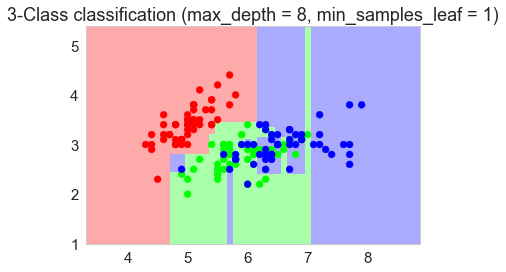

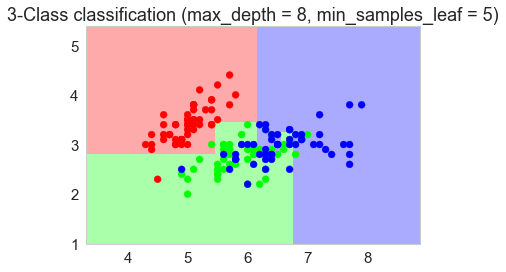

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets

hyperparameters = [(8, 1), (8, 5)]

# import some data to play with
iris = datasets.load_iris()
X_iris = iris.data[:, :2]  # we only take the first two features. We could
# avoid this ugly slicing by using a two-dim dataset
y_iris = iris.target

h = .02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

for max_depth, min_samples_leaf in hyperparameters:
    # we create an instance of a Decision Tree and fit the data.
    clf = tree.DecisionTreeClassifier(max_depth=max_depth, 
                                      min_samples_leaf=min_samples_leaf)
    clf.fit(X_iris, y_iris)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    x_min, x_max = X_iris[:, 0].min() - 1, X_iris[:, 0].max() + 1
    y_min, y_max = X_iris[:, 1].min() - 1, X_iris[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X_iris[:, 0], X_iris[:, 1], c=y_iris, cmap=cmap_bold)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("3-Class classification (max_depth = %i, min_samples_leaf = %i)"
              % (max_depth, min_samples_leaf))

### Is our model overfit?

In [50]:
# Let's take a look at the properties of our DT from the previous instantiation

dt 

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [51]:
# Evaluate model on train set
print(dt.score(X_train, y_train))

# Evaluate model on test set
print(dt.score(X_test, y_test))

1.0
0.554077106789


Here's the documentation for **max_depth**, **min_samples_leaf**, and **min_impurity_split** from the sklearn site:

**max_depth** : int or None, optional (default=None)
* The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

**min_samples_leaf** : int, float, optional (default=1)
* The minimum number of samples required to be at a leaf node

**min_impurity_split** : (float) 
* Threshold for early stopping in tree growth. A node will split if its impurity is above the threshold, otherwise it is a leaf.

### 3.2 Demo: Bias vs. Variance
Control for overfitting in the decision model by adjusting the maximum number of questions (max_depth) or the minimum number of records in each final node (min_samples_leaf)

In [52]:
# Instantiate model with parameters
dt_new = DecisionTreeClassifier(max_depth=5, min_samples_leaf=20)

# Train model on training set
dt_new.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=20,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [53]:
# Evaluate model on train set
print("Accuracy: %0.3f" % dt_new.score(X_train, y_train))

# Evaluate model on test set
print("Accuracy: %0.3f" % dt_new.score(X_test, y_test))

Accuracy: 0.621
Accuracy: 0.606


## Introduction: Ensembles and random forests
**Objective**: Understand random forest models for classification and regression

Let's pretend that instead of building a single model to solve a binary classification problem, you created **five independent models**, and each model was correct about 70% of the time. If you combined these models into an "ensemble" and used their majority vote as a prediction, how often would the ensemble be correct?

## What is ensembling?

![](./images/ensemble_process.png)

**Ensemble learning (or "ensembling")** is the process of combining several predictive models in order to produce a combined model that is more accurate than any individual model.
- **Regression**: take the average of the predictions
- **Classification**: take a vote and use the most common prediction, or take the average of the predicted probabilities

For ensembling to work well, the models must have the following characteristics:
- **Accurate**: they outperform the null model
- **Independent**: their predictions are generated using different processes

    **The big idea**: If you have a collection of individually imperfect (and independent) models, the "one-off" mistakes made by each model are probably not going to be made by the rest of the models, and thus the mistakes will be discarded when averaging the models.
    
![](./assets/images/crowdflower_ensembling.jpg)

### Bagging: bootstrap aggregation

The primary weakness of **decision trees** is that they don't tend to have the best predictive accuracy. This is partially due to **high variance**, meaning that different splits in the training data can lead to very different trees.

**Bagging** is a general purpose procedure for reducing the variance of a machine learning method, but is particularly useful for decision trees. Bagging is short for **bootstrap aggregation**, meaning the aggregation of bootstrap samples.

What is a **bootstrap sample**? A random sample with replacement:

**How does bagging work (for decision trees)?**
1. Grow B trees using B bootstrap samples from the training data.
2. Train each tree on its bootstrap sample and make predictions.
3. Combine the predictions:
 - Average the predictions for regression trees
 - Take a vote for classification trees
 
![title](https://prachimjoshi.files.wordpress.com/2015/07/screen_shot_2010-12-03_at_5-46-21_pm.png)
 
### Random Forests
Random Forests is a slight variation of bagged trees that has even better performance:
- Exactly like bagging, we create an ensemble of decision trees using bootstrapped samples of the training set.
- However, when building each tree, each time a split is considered, a **random sample of m features** is chosen as split candidates from the full set of p features. The split is only allowed to use one of those m features.
- A new random sample of features is chosen for every single tree at every single split.
- For classification, m is typically chosen to be the square root of p.
- For regression, m is typically chosen to be somewhere between p/3 and p.

![title](https://d2wh20haedxe3f.cloudfront.net/sites/default/files/random_forest_diagram_complete.png)

**What's the point?**

Suppose there is **one very strong feature** in the data set. When using bagged trees, most of the trees will use that feature as the top split, resulting in an ensemble of similar trees that are **highly correlated**.
- Averaging highly correlated quantities does not significantly reduce variance (which is the entire goal of bagging).
- By randomly leaving out candidate features from each split, **Random Forests "decorrelates" the trees**, such that the averaging process can reduce the variance of the resulting model.

- Random forest models are one of the most widespread classifiers used.
- They are relatively simple to use and help avoid overfitting.
- Random Forests are an ensemble or collection of individual decision trees.

**Training a Random Forest**

Training a random forest model involves training many decision tree models.

Since decision trees overfit easily, we use many decision trees together and randomize the way they are created.

![](assets/images/tree_ensemble.png)


**Random Forest Algorithm**

1. Take a bootstrap sample of the dataset. (Sample random rows)
2. Train a decision tree on the bootstrap sample.  For each split/feature selection, only evaluate a limited number of features to find the best one.
3. Repeat this for N trees.

**How do I make predictions with a collection of trees?**
- Predictions for a random forest model come from each decision tree.
- Make an individual prediction with each decision tree.
- Combine the individual predictions and take the majority vote or average in the case of regression.

**Why does this work?**
- A tree with a large depth is relatively low bias and high variance
- When we average the predictions of the trees we reduce the variance
- The amazing part is that we don't raise the bias unless the trees are correlated
- We get a sharper estimation of the predictions, just like taking the mean of a large sample vs a small sample

**Real world application**

Ensembling is one of the secret sauces to Kaggle competitions.

Ensembling is not only limited to trees, you can use any other model or a mix of models to ensemble, provided that their predictions are generally uncorrelated and are better than random. 

This means that you should mix models that work differently from each other, such as linear vs non-linear.

### Knowledge Check
* How could a decision tree model overfit a dataset?
* What are some ways to mitigate overfitting in a decision tree?
* What is ensembling? How does it help us develop more robust models?
* What is bagging?
* Where does the 'Random' in Random Forest come from?

## Random Forest Time

In [54]:
from sklearn.ensemble import RandomForestClassifier

In [55]:
# Instantiate a Random Forest Classifier
rf = RandomForestClassifier()

In [56]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

Notice the propertry **n_estimators**. This refers to the number of trees in the forest

In [57]:
# Evaluate model on train set
print("Accuracy: %0.3f" % rf.score(X_train, y_train))

# Evaluate model on test set
print("Accuracy: %0.3f" % rf.score(X_test, y_test))

Accuracy: 0.972
Accuracy: 0.588


### Tune and update the model with grid search

In [58]:
# Set list of values to grid search over

# The number of trees in the rf
n = [1, 3, 10, 30]

# The min number of observations in each leaf
samples = [1, 10, 30]

# How many splits
depth = [None, 3, 5, 7]

# The percentage of max features to look at for each split
# 'auto' means you don't subset the features
features = ['auto', 0.25, 0.5, 0.75, None]

params = {'n_estimators': n,
         'min_samples_leaf':samples,
         'max_depth':depth,
         'max_features':features}

In [59]:
from sklearn.model_selection import GridSearchCV

# Do a 5 fold CV
gs = GridSearchCV(estimator = rf, param_grid = params, n_jobs=-1, verbose = True, cv=5)

In [60]:
gs.fit(X, y)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   50.6s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:  1.2min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [1, 3, 10, 30], 'max_features': ['auto', 0.25, 0.5, 0.75, None], 'max_depth': [None, 3, 5, 7], 'min_samples_leaf': [1, 10, 30]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=True)

In [61]:
# Get best value to use
print("Best Params:")
print(gs.best_params_)

Best Params:
{'max_features': 'auto', 'n_estimators': 30, 'max_depth': 7, 'min_samples_leaf': 10}


The characteristics of the best RFC from Grid Search:
* There are a total of _____ trees in this random forest
* The minimum number of samples required to be in a leaf is _____
* The percentage of features we subset for each split is _____
* Bonus: what is the depth of each of the trees in the random forest?

In [62]:
# Get improvement
print("Accuracy of current model: %0.3f" % rf.score(X_test, y_test))
print("Accuracy using best param: %0.3f" % gs.best_score_)

Accuracy of current model: 0.588
Accuracy using best param: 0.634


In [63]:
# Observe one set of parameters
gs.grid_scores_[0]

/Users/annariehle/anaconda/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


mean: 0.56811, std: 0.01480, params: {'max_features': 'auto', 'n_estimators': 1, 'max_depth': None, 'min_samples_leaf': 1}

What does this mean? Remember, you did a 5 folds cross validation
* The mean accuracy of the is...
* The standard deviation of the accuracy scores of the is...
* The max depth is...
* The minimum number of samples in each life is...
* The number of trees in each forest is...

/Users/annariehle/anaconda/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


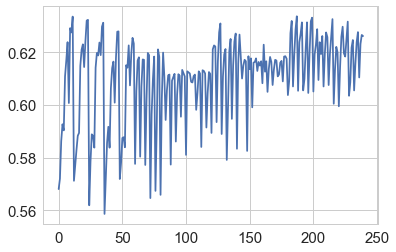

In [64]:
# Plot scores
#gs.grid_scores_
plt.plot([s[1] for s in gs.grid_scores_])

In [65]:
rf = gs.best_estimator_
rf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=10,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [66]:
rf.fit(X_train, y_train)
print(rf.score(X_test, y_test))

0.625383828045


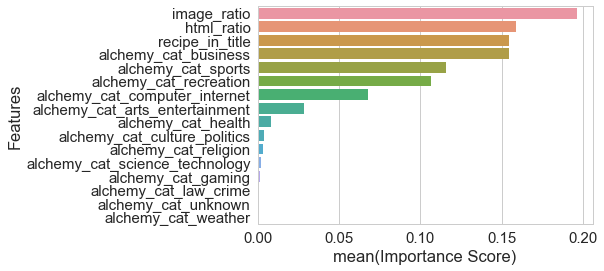

In [67]:
# Examine Feature importances
features = X.columns
feature_importances = rf.feature_importances_

features_df = pd.DataFrame({'Features': features, 'Importance Score': feature_importances})
features_df.sort_values('Importance Score', inplace=True, ascending=False)

sns.barplot(y='Features', x='Importance Score', data=features_df)

In [68]:
# Function to combine dummy features importances
def combine_dummies(dummy_prefixes):
    for p in dummy_prefixes:
        sub_keys = filter(lambda x: x.startswith(p), feature_dict)
        sub_keys_sum = sum([feature_dict[x] for x in sub_keys])
        for k in sub_keys: feature_dict.pop(k)
        feature_dict[p] = sub_keys_sum
    return feature_dict

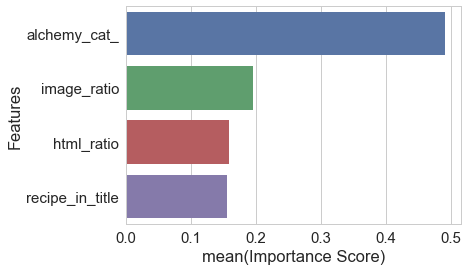

In [69]:
# Plot importances with dummy features combined
feature_names = X.columns
feature_importances = rf.feature_importances_
feature_dummy_prefixes = ['alchemy_cat_']

feature_dict = dict(zip(feature_names, feature_importances))
feature_dict = combine_dummies(feature_dummy_prefixes)

features_df = pd.DataFrame(list(feature_dict.items()), columns=['Features', 'Importance Score'])
features_df.sort_values('Importance Score', inplace=True, ascending=False)

#features_df['Importance Score'].sum()
sns.barplot(y='Features', x='Importance Score', data=features_df)

## Mini-Lab - Partner-Up

#### Let's continue modeling the StumpleUpon data!

(1) Split up the remaining features and do some EDA. What other features are correlated with label?
* Since there are a lot of numerical fields, try engineering the features as opposed to just using the raw data (try binning).
* Think about other generalizations you can pull out from the boilerplate column (what phrases do you think attracts people to go to a site more than once? hhat about the URL could you pull out?)

In [80]:
df.corr().abs().sort_values('label', ascending=False)

,urlid,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,compression_ratio,embed_ratio,framebased,frameTagRatio,...,html_ratio,image_ratio,lengthyLinkDomain,linkwordscore,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,label
label,0.013450,0.006172,0.083364,0.083488,0.105964,0.080464,0.059737,0.039536,NaN,0.187762,...,0.051149,0.017266,0.032824,0.173800,0.097580,0.080187,0.024823,0.010668,0.058578,1.000000
frameTagRatio,0.010065,0.049270,0.294860,0.259222,0.218559,0.178064,0.159335,0.130753,NaN,1.000000,...,0.384937,0.088847,0.196673,0.158874,0.303682,0.362491,0.049330,0.094557,0.033663,0.187762
linkwordscore,0.013668,0.122550,0.257200,0.257594,0.109654,0.059223,0.146470,0.108476,NaN,0.158874,...,0.141363,0.051436,0.130844,1.000000,0.379487,0.171880,0.011236,0.000052,0.025707,0.173800
commonlinkratio_3,0.005285,0.174554,0.560584,0.758330,1.000000,0.850604,0.016188,0.007578,NaN,0.218559,...,0.133370,0.050357,0.363159,0.109654,0.264022,0.283924,0.049203,0.008652,0.008599,0.105964
non_markup_alphanum_characters,0.016732,0.010982,0.193914,0.177785,0.264022,0.162883,0.064163,0.046484,NaN,0.303682,...,0.136550,0.026655,0.203278,0.379487,1.000000,0.375584,0.076632,0.012631,0.010207,0.097580
commonlinkratio_2,0.008407,0.161769,0.808047,1.000000,0.758330,0.555148,0.032460,0.019387,NaN,0.259222,...,0.159702,0.044663,0.398817,0.257594,0.177785,0.311492,0.096940,0.079485,0.027888,0.083488
commonlinkratio_1,0.002856,0.120467,1.000000,0.808047,0.560584,0.388801,0.017878,0.005280,NaN,0.294860,...,0.201501,0.064435,0.421284,0.257200,0.193914,0.317293,0.144354,0.078026,0.035019,0.083364
commonlinkratio_4,0.009573,0.134527,0.388801,0.555148,0.850604,1.000000,0.020415,0.005473,NaN,0.178064,...,0.136561,0.038071,0.287159,0.059223,0.162883,0.233898,0.026384,0.036387,0.013507,0.080464
numberOfLinks,0.002019,0.000360,0.317293,0.311492,0.283924,0.233898,0.055388,0.042942,NaN,0.362491,...,0.455636,0.091977,0.307005,0.171880,0.375584,1.000000,0.068791,0.136482,0.001343,0.080187
compression_ratio,0.007343,0.003578,0.017878,0.032460,0.016188,0.020415,1.000000,0.889345,NaN,0.159335,...,0.106335,0.188976,0.090325,0.146470,0.064163,0.055388,0.042614,0.033772,0.364122,0.059737


(2) Pick up to six additional variables total to add to the model (you can include/exclude the variables from the previous example)

In [81]:
features = ['frameTagRatio','linkwordscore','non_markup_alphanum_characters', 'numberOfLinks', 'compression_ratio', 'spelling_errors_ratio']
X = df[features]
y = df.label

(3) Create a Decision Tree 
* Remember to do cross-validation to see if your model is overfit
* Try pruning the tree by selecting the max number of splits and minimum number of samples required in each leaf


In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

# Evaluate accuracy of model on test set
print("Accuracy: %0.3f" % dt.score(X_test, y_test))

# Evaluate ROC AUC score of model on test set
print('ROC AUC: %0.3f' % roc_auc_score(y_test, dt.predict_proba(X_test)[:,1]))

Accuracy: 0.566
ROC AUC: 0.565


(4) Repeat step 3 but with a Random Forest


In [83]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Evaluate model on train set
print("Accuracy: %0.3f" % rf.score(X_train, y_train))

# Evaluate model on test set
print("Accuracy: %0.3f" % rf.score(X_test, y_test))

Accuracy: 0.982
Accuracy: 0.604


(5) Run a Grid Search with 3 different values for each of the following parameters:
* The number of trees in the forest (n_estimators)
* The minimum number of samples in each leaf (min_samples_leaf)
* The maximum number of splits (max_depth)
* The percentage of features to look at during each of the splits (max_features)

In [85]:
# Set list of values to grid search over

# The number of trees in the rf
n = [1, 5, 10, 15]

# The min number of observations in each leaf
samples = [1, 50, 100]

# How many splits
depth = [3, 5, 7, 9]

# The percentage of max features to look at for each split
# 'auto' means you don't subset the features
features = ['auto', 0.25, 0.5, 0.75, None]

params = {'n_estimators': n,
         'min_samples_leaf':samples,
         'max_depth':depth,
         'max_features':features}

# Do a 5 fold CV
gs = GridSearchCV(estimator = rf, param_grid = params, n_jobs=-1, verbose = True, cv=5)

gs.fit(X, y)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 744 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:   55.3s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [1, 5, 10, 15], 'max_features': ['auto', 0.25, 0.5, 0.75, None], 'max_depth': [3, 5, 7, 9], 'min_samples_leaf': [1, 50, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=True)

What combination of parameters gave you the most accurate model?

In [86]:
gs.grid_scores_[0]

/Users/annariehle/anaconda/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


mean: 0.60757, std: 0.01093, params: {'max_features': 'auto', 'n_estimators': 1, 'max_depth': 3, 'min_samples_leaf': 1}